In [2]:
#from mnist_gan.mnistGan import MnistGan
from mnist_cnn.mnistCnn import MnistCnn
#from mnist_cnn.mnistDatasetLoader import MnistDatasetLoader
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.nn import dilation2d
from tensorflow.nn import erosion2d

In [3]:
def opening(img, structuring_element):
    erosion = erosion2d(img, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    output = dilation2d(erosion, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    return output

def closing(img, structuring_element):
    dilation = dilation2d(img, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    output = erosion2d(dilation, filters = structuring_element, strides = (1,1,1,1), padding = 'SAME', data_format = 'NHWC', dilations = (1,1,1,1))
    return output

#open-close-close-open
def occo(img, structuring_element):
    op = opening(img, structuring_element)
    open_close = closing(op, structuring_element)
    cl = closing(img, structuring_element)
    close_open = opening(cl, structuring_element)
    return (open_close + close_open)/2

In [14]:
cnn = MnistCnn(largerModel = True)
cnn.loadWeights('mnist_cnn/largerCnn30Epochs')

In [17]:
(X_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_data = X_train.copy()
img_data = img_data.reshape(X_train.shape[0], 28, 28, 1)
img_data = img_data / 255
print(img_data.shape)

x_test = np.expand_dims(x_test, -1)
y_test_one_hot = np.eye(10, dtype = float)[y_test]
x_test = x_test/255
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [16]:
#evaluate cnn
results = cnn.model.evaluate(x_test, y_test_one_hot, batch_size = 128)
print("test loss, test acc: ", results)

79/79 [==============================] - 0s 2ms/step - loss: 0.0207 - accuracy: 0.9950
test loss, test acc:  [0.020660925656557083, 0.9950000047683716]


In [26]:
@tf.function
def g(x, index, classifier):
    res = -tf.math.log(tf.squeeze(classifier(x))[index])
    return res

def explain(x, structuring_element, classifier, maxIter, maxChange, minAlpha):
    epsilon = 1e-16
    closeEnough = False
    iter = 0
    index = tf.argmax(tf.squeeze(classifier(x))).numpy()
    
    while(not closeEnough and iter < maxIter):
        with tf.GradientTape() as tape:
            gRes = g(x, index, classifier)
        grad = tape.gradient(gRes, x)
        grad = occo(grad, structuring_element)
        maxGrad = tf.abs(tf.reduce_max(grad))
        alpha = tf.minimum(minAlpha, maxChange/tf.maximum(maxGrad, epsilon))
        x.assign(x + alpha * grad)
        x.assign(tf.clip_by_value(x, clip_value_min = 0, clip_value_max = 1))
        #x.assign(occo(x, structuring_element))
        iter += 1
        newIndex = tf.argmax(tf.squeeze(classifier(x))).numpy()
        if (newIndex != index): # done when the prediction has changed
            closeEnough = True
    print("done after ", iter, " steps")

[4.9869258e-12 9.2838098e-12 4.2215030e-13 1.0857502e-10 1.0071720e-06
 8.1445746e-11 2.4030894e-12 2.5519112e-08 3.5601346e-09 9.9999893e-01]
done after  90  steps
origY:  tf.Tensor(9, shape=(), dtype=int64)
newY:  tf.Tensor(8, shape=(), dtype=int64)


Text(0.5, 1.0, 'old')

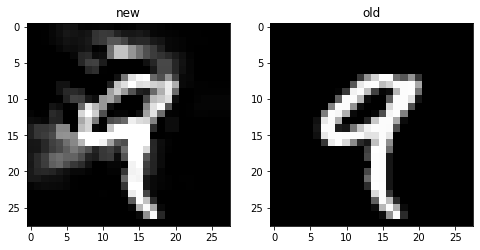

In [31]:
image = img_data[4]
x_ = tf.cast(np.expand_dims(image, 0), tf.float32)
x = tf.Variable(x_)
print(cnn.predict(x).numpy().squeeze())
origY = tf.argmax(cnn.predict(x).numpy().squeeze())
se = tf.ones((2,2,1))

explain(x, se, cnn.model, 600, maxChange = 0.099, minAlpha = 1000)

newY = tf.argmax(cnn.predict(x).numpy().squeeze())
print("origY: ", origY)
print("newY: ", newY)

_, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(x[0], cmap = 'gray')
ax[0].set_title('new')
ax[1].imshow(image, cmap = 'gray')
ax[1].set_title('old')